# Logistic Regression

## School admittance example data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Issue with `import matplotlib.pyplot as plt` on OSX? See this [stack overflow](https://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python) answer.
```
import matplotlib as mpl 
mpl.use('TkAgg')
import matplotlib.pyplot as plt
```

In [2]:
import os
path = os.getcwd() + '/data/ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [3]:
# Panda's data frames of positive and negative examples
positive = data[data['Admitted'].isin([1])]  
negative = data[data['Admitted'].isin([0])]

Text(0, 0.5, 'Exam 2 Score')

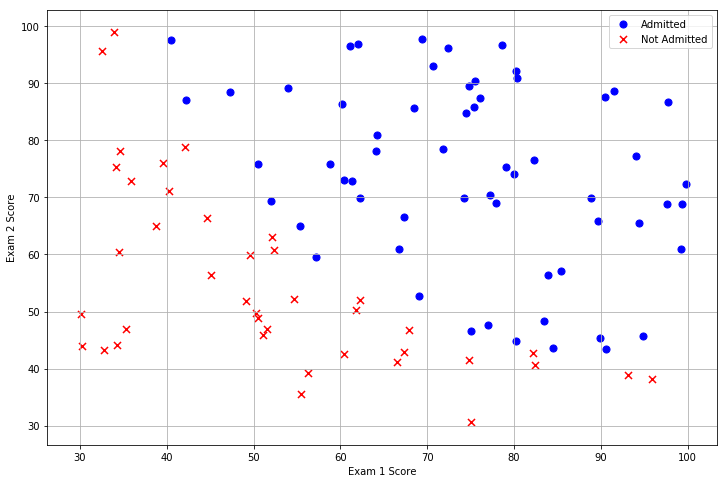

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))  
ax.grid(True)
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='b', marker='o', label='Admitted')  
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')  
ax.legend()  
ax.set_xlabel('Exam 1 Score')  
ax.set_ylabel('Exam 2 Score')  

## Set up the data

In [5]:
# add a ones column - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:, 0:cols-1]
y = data.iloc[:, cols-1:cols]

# convert to numpy arrays and initialize the parameter array theta
X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(3)

In [6]:
X.shape, theta.shape, y.shape

((100, 3), (3,), (100, 1))

### Hypothesis
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

In [8]:
from scipy.special import expit  # Vectorized sigmoid function

def h(theta, X):
    """Todo: not too sure why dot product works for theta.T*X"""
    return expit(np.dot(X, theta))

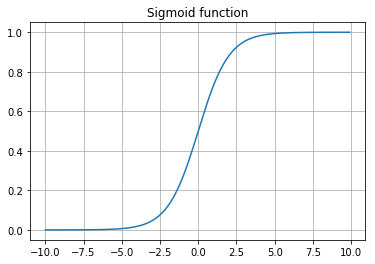

In [9]:
myx = np.arange(-10,10,.1)
plt.plot(myx,expit(myx))
plt.title("Sigmoid function")
plt.grid(True)

### Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$
#### ...vectorized
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big)$$

#### Regularized Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### ...vectorized
#### $$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

In [10]:
def cost(theta, X, y, learning_rate=0.): 
    """Calculate the total cost for every example with a set of parameter values.
    
    Set learning_rate to non-zero to include regularization.

    :param numpy.ndarray theta: An n- dimensional vector of initial parameter values
    :param numpy.ndarray X: An array of examples with n columns and m rows
    :param numpy.ndarray y: The labeled prediction, m rows and 1 column
    :param float learning_rate: parameter to tune the weight regularization holds on the cost function
    
    :rtype: float
    """
    m = len(y)
    term1 = np.dot(-np.array(y).T, np.log(h(theta, X)))
    term2 = np.dot((1-np.array(y)).T, np.log(1-h(theta, X)))
    regterm = (learning_rate/2) * np.sum(np.dot(theta[1:].T, theta[1:])) #Skip theta0
    return float( (1./m) * ( np.sum(term1 - term2) + regterm ) )

In [11]:
# cost with theta initialized to 0
cost(theta, X, y, 0)

0.6931471805599453

### Gradient (partial derivative)

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} $$ 
#### ...vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y)$$


#### Regularized Gradient

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
#### ...vectorized
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$
##### $$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$

In [12]:
def gradient(theta, X, y, learning_rate):
    """Calculate a single gradient step.
    
    Only compute a single gradient step so this function can be used with an optimization function.
    
    :param numpy.ndarray theta: An array of parameter values to use
    :param numpy.ndarray X: An array of examples
    :param numpy.ndarray y: The labeled prediction for each example
    :param int learning_rate: parameter to tune the weight regularization holds on the cost function
    
    :return: An ndarray[int] of gradient values
    :rtype: numpy.ndarray
    """
    # convert to np matrices for convenience of np's matrix operations
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    m = len(X)

    # find number of parameters and initialize a gradient value for each
    parameters = int(theta.ravel().shape[1])  # shape[1] only exists for matrix, not array
    grad = np.zeros(parameters)
    
    # calculate the error term to use in the gradient function
    # h(x) - y
    error = h(theta.T, X) - y  # error is an ndarray for each matrix operation
    
    # calculate the gradient value for each parameter using the error value
    # (1/m) * sum(error*x)
    for i in range(parameters):
        term = np.multiply(error, X[:, i])
        
        # skip regularization for theta_0
        if i == 0:
            grad[i] = (1/m) * np.sum(term)  # sum the values for every matrix operation
        else:
            grad[i] = (1/m) * np.sum(term) + ((learning_rate / m) * theta[:, i])
        
    return grad

## Optimize the parameters
scipy has similar optimization functions to Matlab's `fminunc`. `fmin_tnc` wraps a C implementation of the truncated Newton algorithm, and returns the optimized parameters, number of iterations used, and an return code.

In [13]:
from scipy import optimize

result = optimize.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y, 0))
print("Optimal theta values:", result[0], "-", type(result[0]))
print("in", result[1], "iterations.")

Optimal theta values: [-25.16131858   0.20623159   0.20147149] - <class 'numpy.ndarray'>
in 36 iterations.


In [14]:
# result[0] is an np.ndarray with the optimal theta values
print("Optimal cost", cost(result[0], X, y, 0))

Optimal cost 0.20349770158947478


### Alternative without derivative terms

scipy's `fmin` only needs the cost function.

In [15]:
def optimizeTheta(theta, X, y, learning_rate=0.):
    result = optimize.fmin(cost, x0=theta, args=(X, y, learning_rate), maxiter=400, full_output=True)
    return result[0], result[1]

In [16]:
theta, mincost = optimizeTheta(theta, X, y)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [17]:
print("Optimal theta values:", theta, "-", type(theta))

Optimal theta values: [-25.16130062   0.20623142   0.20147143] - <class 'numpy.ndarray'>


## Plot the decision boundary

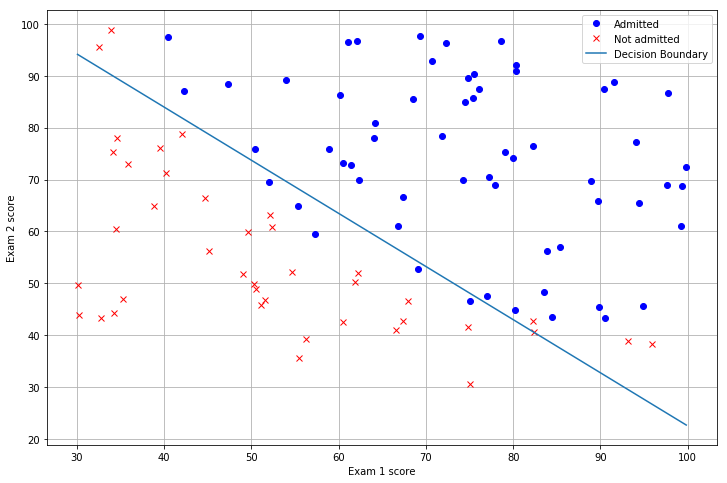

In [18]:
# now try using np array's to plot data
pos = np.array([array for i, array in enumerate(X) if y[i] == 1])
neg = np.array([array for i, array in enumerate(X) if y[i] == 0])

plt.figure(figsize=(12, 8))
plt.plot(pos[:, 1], pos[:, 2], 'bo', label='Admitted')
plt.plot(neg[:, 1], neg[:, 2], 'rx', label='Not admitted')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend()
plt.grid(True)

# pick two points on decision boundary, draw a line
# h = 0 OR theta0 + theta1*x1 + theta2*x2 = 0
# y = mx + b is replaced by x2 = (-1/thetheta2)(theta0 + theta1*x1)
boundary_xs = np.array([np.min(X[:, 1]), np.max(X[:, 1])])
boundary_ys = (-1./theta[2]) * (theta[0] + theta[1]*boundary_xs)
plt.plot(boundary_xs, boundary_ys, '-', label='Decision Boundary')

plt.legend()

In [19]:
# For a student with scores of 45 and 85...
print(h(theta, np.array([1, 45., 85.])))

0.7762915904112411


## Make some predictions

In [20]:
def predict(theta, X):
    """Applies the logistic regression hypothesis to a data set and given parameters.
    
    :param numpy.ndarray theta: Matrix of theta values
    :param numpy.ndarray X: Array of examples to predict
    
    :returns: A list of 1s or 0s for each entry in X
    :rtype: list[int]
    """
    probability = h(theta, X)
    return [1 if x >= 0.5 else 0 for x in probability]

Make a prediction on the training set (X). This value is probably high though, because some data should be held out for a cross validation set.

In [21]:
predictions = predict(theta, X)  # X is still an ndarray
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0))
           else 0
           for (a, b) in zip(predictions, y)]

# sum(map(int, correct)) is total number of 1s in correct, a vector of 1s and 0s
# modulus this with the length of the vector for the accuracy
accuracy = (sum(map(int, correct)) % len(correct))
print('accuracy: ', accuracy)

accuracy:  89


# Regularization

## Microchip test data set

In [22]:
datafile = 'data/ex2data2.txt'
cols = np.loadtxt(datafile, delimiter=',', usecols=(0,1,2), unpack=True) 

X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size
X = np.insert(X,0,1,axis=1)

pos = np.array([arr for i, arr in enumerate(X) if y[i] == 1])
neg = np.array([arr for i, arr in enumerate(X) if y[i] == 0])

In [23]:
def plot_data():
    plt.plot(pos[:,1], pos[:,2], 'bo', label='y=1')
    plt.plot(neg[:,1], neg[:,2], 'rx', label='y=0')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()
    plt.grid(True)

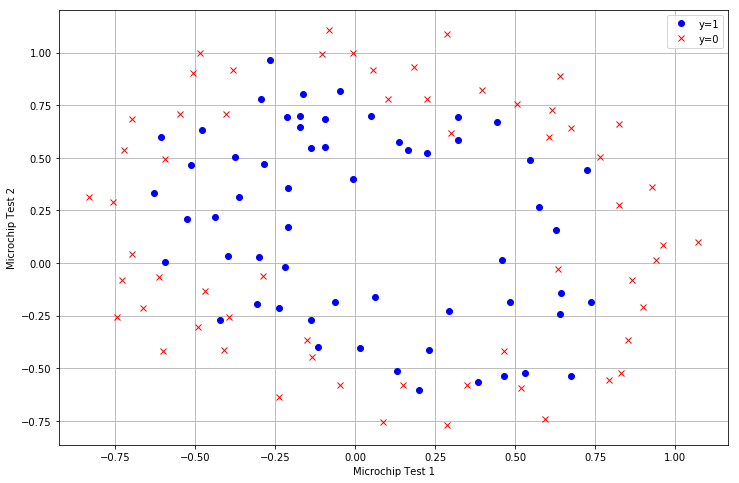

In [24]:
plt.figure(figsize=(12, 8))
plot_data()


## Feature Mapping

In [25]:
def map_feature(x1col, x2col):
    """Builds a n x 28 matrix of features from two given columns of inputs."""
    degrees = 6
    out = np.ones( (x1col.shape[0], 1) )

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out

In [26]:
# feature mapped X matrix
mapped_X = map_feature(X[:, 1], X[:, 2])
mapped_X[1]

array([ 1.00000000e+00, -9.27420000e-02,  6.84940000e-01,  8.60107856e-03,
       -6.35227055e-02,  4.69142804e-01, -7.97681228e-04,  5.89122275e-03,
       -4.35092419e-02,  3.21334672e-01,  7.39785525e-05, -5.46363780e-04,
        4.03513411e-03, -2.98012201e-02,  2.20094970e-01, -6.86091891e-06,
        5.06708697e-05, -3.74226408e-04,  2.76382476e-03, -2.04120477e-02,
        1.50751849e-01,  6.36295342e-07, -4.69931780e-06,  3.47065055e-05,
       -2.56322636e-04,  1.89305413e-03, -1.39810280e-02,  1.03255971e-01])

## Cost and Gradient

In [27]:
initial_theta = np.zeros((mapped_X.shape[1], 1))
cost(initial_theta, mapped_X, y,)

0.6931471805599454

### Optimize theta and cost
This time using `optimize.minimize` instead of `optimize.fmin`.

In [33]:
def optimize_regularized_theta(theta, X, y, learning_rate=0.):
    result = optimize.minimize(cost, theta, args=(X, y, learning_rate),  method='BFGS', options={"maxiter":500, "disp":False} )
    return np.array([result.x]), result.fun
    
theta, mincost = optimize_regularized_theta(initial_theta, mapped_X, y)
print("theta:", theta)
print("mincost:", mincost)

theta: [[   19.52269435    31.84021967    15.93788001  -190.59852033
    -83.6310338    -98.81513102  -233.83620851  -193.6262234
   -126.49477953   -39.68194579   654.79419846   498.84620123
    809.25583976   333.21416156   179.28156264   398.43147555
    516.98904945   614.16108487   356.15731339   128.46448539
     34.75456847  -766.47577043  -893.15487474 -1496.38858574
  -1031.0223571  -1009.97014316  -377.80312391  -121.72362368]]
mincost: 0.24863999275541845


## Plotting decision boundaries

In [31]:
def plot_boundary(theta, X, y, learning_rate=0):
    theta, mincost = optimize_regularized_theta(theta, X, y, learning_rate)
    xvals = np.linspace(-1, 1.5, 50)
    yvals = np.linspace(-1, 1.5, 50)
    zvals = np.zeros((len(xvals), len(yvals)))
    
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            featuresij = map_feature(np.array([xvals[i]]), np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta, featuresij.T)
    zvals = zvals.transpose()

    u, v = np.meshgrid( xvals, yvals )
    mycontour = plt.contour( xvals, yvals, zvals, [0])
    plt.title("Learning Rate {}".format(learning_rate))

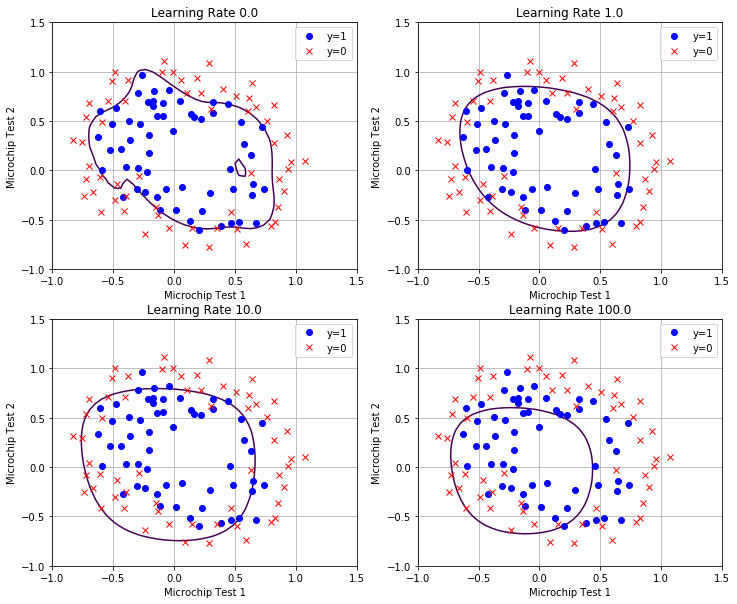

In [32]:
plt.figure(figsize=(12, 10))
plt.subplot(221)
plot_data()
plot_boundary(theta, mapped_X, y, 0.)

plt.subplot(222)
plot_data()
plot_boundary(theta, mapped_X, y, 1.)

plt.subplot(223)
plot_data()
plot_boundary(theta, mapped_X, y, 10.)

plt.subplot(224)
plot_data()
plot_boundary(theta, mapped_X, y, 100.)